![Телеграмм Чат](./../../img/cover.jpg)

# Практика Autoencoder

В этом примере мы разберем пример детекции аномалии в временном ряду.

![](https://www.mdpi.com/sensors/sensors-21-06679/article_deploy/html/images/sensors-21-06679-g001.png)


Идея применения автоэнкодера для детекции аномалий проста. Мы хорошо обучим автоэнкодер на восстановлении данных, модель запомни какие данные могут быть (то есть более вероятные для данного набора распределения). В случае когда модель увидит аномальные значения то лосс модели будет очень большим, следовательно входные данные сильно отличаются от исходного распределения, а значит это аномалии.  

# Датасет

Мы будем использовать датасет Numenta Anomaly Benchmark (NAB) — это новый тест для оценки алгоритмов обнаружения аномалий в потоковых онлайн-приложениях.

Для обучения возьмем в пример два набора данных
 - `art_daily_small_noise.csv` данные с шумом, без аномалий
 - `art_daily_jumpsup.csv` данные с шумом, с аномалиями

In [23]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt

In [10]:
base = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

sm_noise = "artificialNoAnomaly/art_daily_small_noise.csv"
df_sm_noise = pd.read_csv(
    base+sm_noise, parse_dates=True, index_col="timestamp"
)

sm_anomaly = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_anomaly = pd.read_csv(
    base+sm_anomaly, parse_dates=True, index_col="timestamp"
)

# Визуализация данных

Посмотрим на данные

Данные без аномалий

In [11]:
df_sm_noise.head()

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


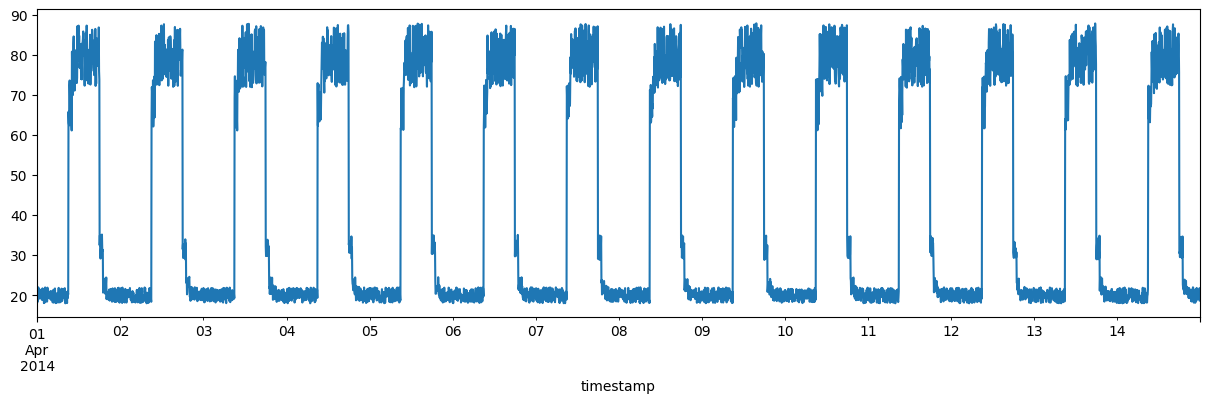

In [17]:
df_sm_noise.plot(legend=False, figsize=(15, 4));

Данные с аномалиями

In [13]:
df_anomaly.head()

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739


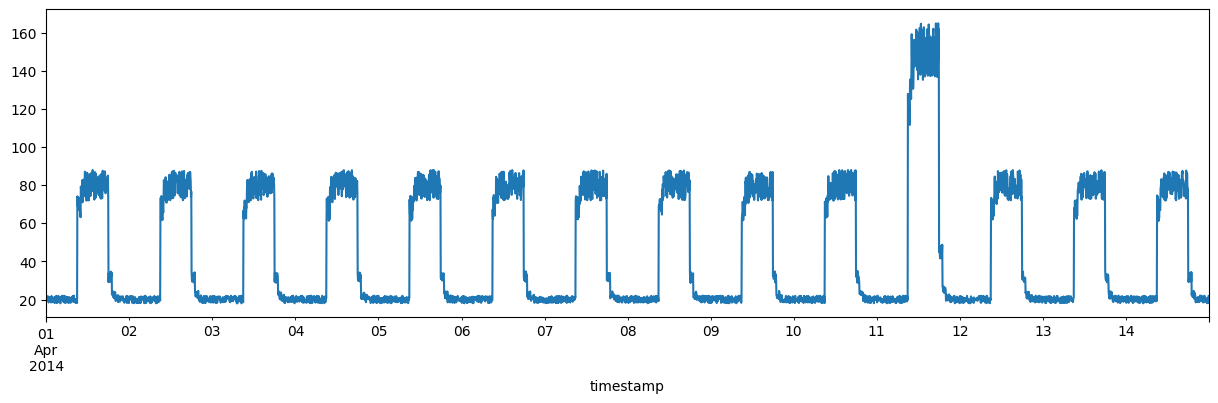

In [18]:
df_anomaly.plot(legend=False, figsize=(15, 4));

# Предобработка

Для обучения нормализируем данные. 

В датасете данные записаны с переодичностью в 5 минут.

-   24 * 60 / 5 = **288 значение в день**
-   288 * 14 = **4032 значений** всего

In [20]:
training_mean = df_sm_noise.mean()
training_std = df_sm_noise.std()
df_training_value = (df_sm_noise - training_mean) / training_std

Создадим последовательность длительностю в 24 часа и разделим на обучающую и валидационную 

In [21]:
TIME_STEPS = 288

def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    return torch.FloatTensor(output).permute(0, 2, 1)

X = create_sequences(df_training_value.values)
x_train, x_val = train_test_split(X, test_size=0.9, shuffle=False)
print("Обучающая размерность: ", x_train.shape)

train_loader = torch.utils.data.DataLoader(x_train, batch_size=4)
val_loader = torch.utils.data.DataLoader(x_val, batch_size=4)

Обучающая размерность:  torch.Size([374, 1, 288])


/var/folders/04/9qjmf8kx0nb94d4dbczk9bd00000gn/T/ipykernel_86814/3076700180.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  return torch.FloatTensor(output).permute(0, 2, 1)


# Модель обучения

Мы будем использовать сверточный автоэнкодер принимающий на вход тензор размерностью `(batch_size, sequence_length, num_features)` и возвращать тензор той же размерности. В нашем случае `sequence_length = 288` и
`num_features = 1`.

In [22]:
class Autoencoder(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Conv1d(1, 32, kernel_size=7, stride=1, padding=3),
        nn.ReLU(),
        nn.Conv1d(32, 16, kernel_size=7, stride=1, padding=3),
        nn.ReLU(),
    )
    self.decoder = nn.Sequential(
        nn.ConvTranspose1d(16, 16, kernel_size=7, stride=1, padding=3),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.ConvTranspose1d(16, 32, kernel_size=7, stride=1, padding=3),
        nn.ReLU(),
        nn.ConvTranspose1d(32, 1, kernel_size=7, stride=1, padding=3),
    )

  def forward(self, sample):
    latent = self.encoder(sample)
    reconstructed = self.decoder(latent)
    return reconstructed

# Обучение модели 

Заметим, что поскольку мы занимаемся реконструкцией, train/val у нас выступает как в роли входа для сети, так и в роли таргета

In [32]:
n_epochs = 100 # количество эпох обучения 
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'# устройство на котором будем обучать сеть

model = Autoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = F.mse_loss
train_losses = []
val_losses = []
pbar = tqdm(range(n_epochs))

for ichar in pbar:
    model.train()
    train_losses_per_epoch = []
    for i, X_batch in enumerate(train_loader):
        optimizer.zero_grad()
        reconstructed = model(X_batch.to(device))
        loss = loss_fn(reconstructed, X_batch.to(device))
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    pbar.set_postfix({'loss :': np.mean(train_losses_per_epoch)})
    train_losses.append(np.mean(train_losses_per_epoch))

    model.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for X_batch in val_loader:
          reconstructed = model(X_batch.to(device))
          loss = loss_fn(reconstructed, X_batch.to(device))
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))


100%|██████████| 100/100 [01:26<00:00,  1.16it/s, loss :=0.000226]


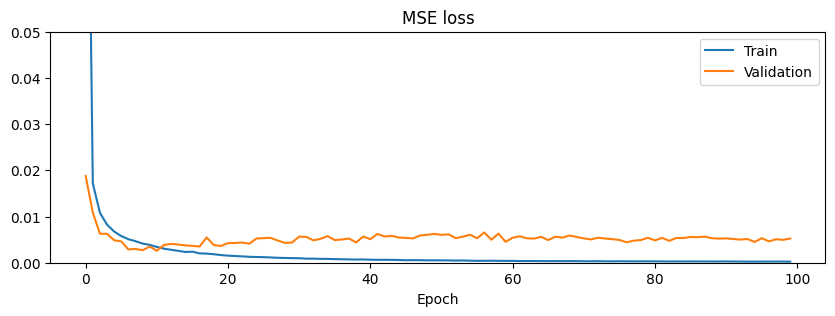

In [33]:
plt.figure(figsize=(10, 3))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
plt.plot(np.arange(len(val_losses)), val_losses, label='Validation')

plt.ylim(0, 0.05)
plt.xlabel('Epoch')
plt.title('MSE loss')
plt.legend()
plt.show()

# Детекция аномалий

Как мы уже говорили раньше, мы будем детектировать аномалии на основании того, насколько хорошо сеть воссоздает исходную последовательность. Более подробно


1.   Посчитаем MAE на трейне.
2.   Найдем максимум MAE на трейне. Это будет нашим порогом (`threshold`) для детекции (мы считаем, что на трейне аномалий нет)
3.   Если лосс больше `threshold`, то скорее всего у нас встретился паттерн, который автоэнкодер не видел при обучении. Будем считать его аномалией


In [34]:
X_loader = torch.utils.data.DataLoader(X, batch_size=1)
model.eval()
threshold = 0.0
x_pred = []

with torch.no_grad():
  for batch in X_loader:
    pred = model(batch.to(device)).cpu().numpy()
    x_pred.append(pred.ravel())
    mae_loss = np.mean(np.abs(pred - batch.numpy()))

    if mae_loss > threshold:
      threshold = mae_loss

print("Reconstruction error threshold: ", threshold)

Reconstruction error threshold:  0.069455504


Давайте посмотрим, насколько хорошо наша модель воспроизводит данные с первого для:

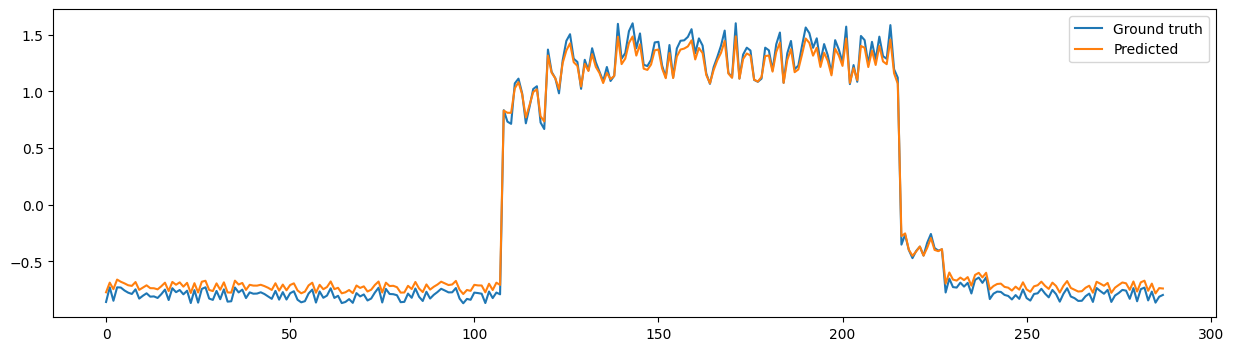

In [35]:
# Checking how the first sequence is learnt
plt.figure(figsize=(15, 4))
plt.plot(x_train[0].numpy().ravel(), label='Ground truth')
plt.plot(x_pred[0], label='Predicted')

plt.legend()
plt.show()

# Детекция на тестовых данных

Проделаем все, о чем мы говорили раньше:

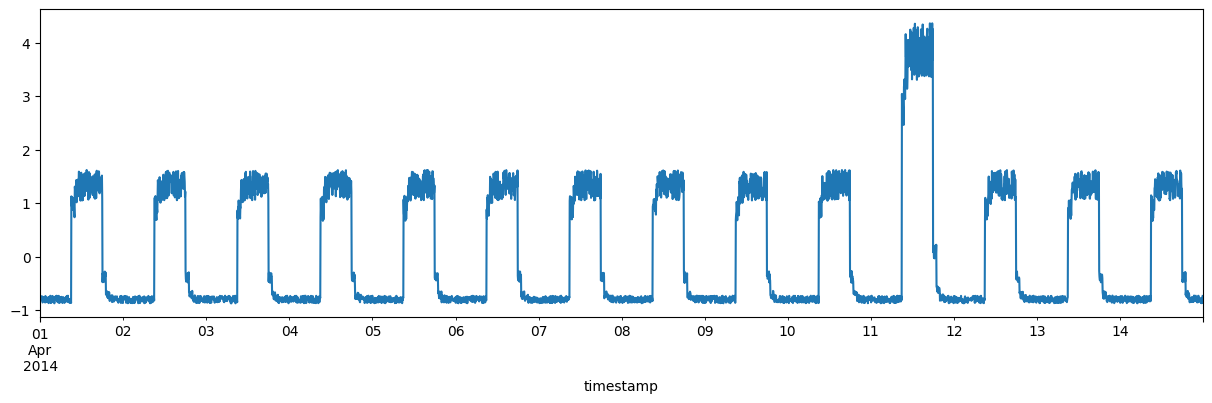

Test input shape:  torch.Size([3744, 1, 288])


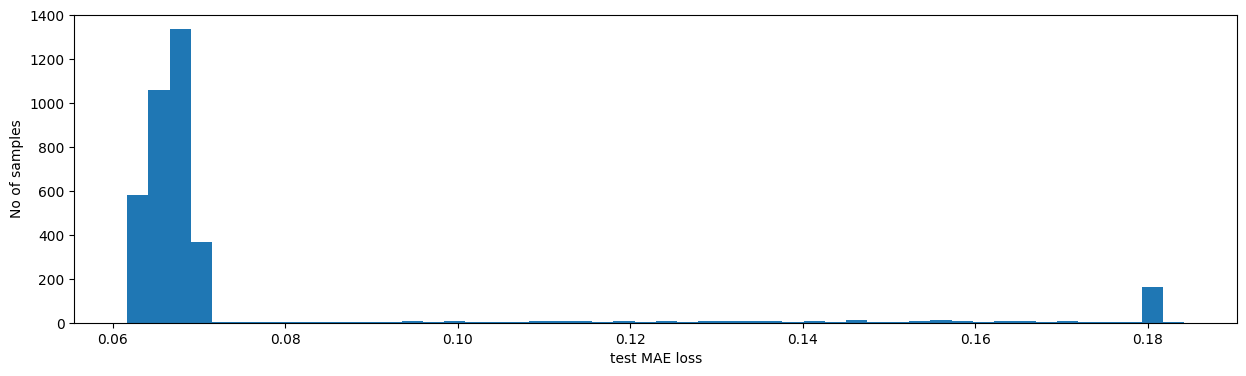

Number of anomaly samples:  666
Indices of anomaly samples:  [426 427 428]


In [43]:
df_test_value = (df_anomaly - training_mean) / training_std
fig, ax = plt.subplots(figsize=(15, 4))
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
test_loader = torch.utils.data.DataLoader(x_test, shuffle=False)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.

test_losses = []
with torch.no_grad():
  for batch in test_loader:
    pred = model(batch.to(device)).cpu().numpy()
    mae_loss = np.mean(np.abs(pred - batch.numpy()))
    test_losses.append(mae_loss)

test_losses = np.array(test_losses).reshape((-1))

plt.figure(figsize=(15, 4))
plt.hist(test_losses, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_losses > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies)[0][:3])

Как мы видим, некоторые индексы помечены как аномальные. Давайте теперь определим границы аномалий и изобразим их на графике

# Графики аномалий

Теперь мы хотим найти аномальные `timestamps` из теста. Будем делать так:

Пусть к примеру `time_steps = 3` и в нашей выборке 10 значений. Наш `x_train` будет выглядеть так:

- 0, 1, 2
- 1, 2, 3
- 2, 3, 4
- 3, 4, 5
- 4, 5, 6
- 5, 6, 7
- 6, 7, 8
- 7, 8, 9

Все значения, кроме начального и последних `time_steps - 1`, появятся в данных
`time_steps` number of samples.  Поэтому, если мы знаем, что последовательности
[(3, 4, 5), (4, 5, 6), (5, 6, 7)] – это аномалии, мы можем сказать, что аномалия произошла в момент времени 5

In [44]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

Изобразим на графике тестовые данные

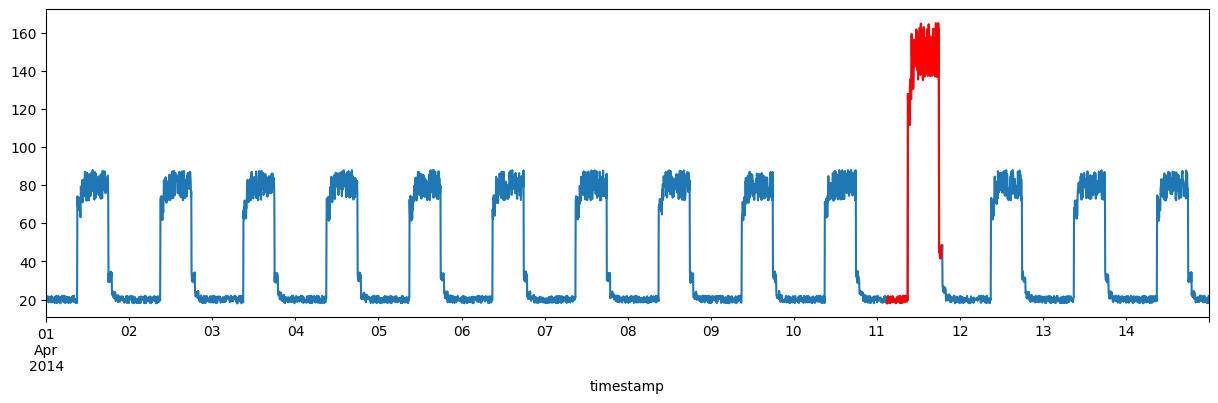

In [45]:
df_subset = df_anomaly.iloc[anomalous_data_indices]
fig, ax = plt.subplots(figsize=(15, 4))
df_anomaly.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()